# jobflow

## Define workflow with jobflow

In [1]:
import numpy as np

In [2]:
from jobflow import job, Flow

/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
from python_workflow_definition.jobflow import write_workflow_json

In [4]:
from quantum_espresso_workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [5]:
workflow_json_filename = "jobflow_qe.json"

In [6]:
calculate_qe = job(_calculate_qe, data=["energy", "volume", "structure"])
generate_structures = job(_generate_structures, data=[f"s_{i}" for i in range(100)])
plot_energy_volume_curve = job(_plot_energy_volume_curve)
get_bulk_structure = job(_get_bulk_structure)

In [7]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [8]:
structure = get_bulk_structure(
    element="Au",
    a=4.05,
    cubic=True,
)

In [9]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure.output,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
)

In [10]:
number_of_strains = 5
structure_lst = generate_structures(
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
)

In [11]:
job_strain_lst = []
for i in range(number_of_strains):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": getattr(structure_lst.output, f"s_{i}"),
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
    )
    job_strain_lst.append(calc_strain)

In [12]:
plot = plot_energy_volume_curve(
    volume_lst=[job.output.volume for job in job_strain_lst],
    energy_lst=[job.output.energy for job in job_strain_lst],
)

In [13]:
flow = Flow([structure, calc_mini, structure_lst] + job_strain_lst + [plot])

In [14]:
write_workflow_json(flow=flow, file_name=workflow_json_filename)

In [15]:
!cat {workflow_json_filename}

{"nodes": [{"id": 0, "function": "quantum_espresso_workflow.get_bulk_structure"}, {"id": 1, "function": "quantum_espresso_workflow.calculate_qe"}, {"id": 2, "function": "quantum_espresso_workflow.generate_structures"}, {"id": 3, "function": "quantum_espresso_workflow.calculate_qe"}, {"id": 4, "function": "quantum_espresso_workflow.calculate_qe"}, {"id": 5, "function": "quantum_espresso_workflow.calculate_qe"}, {"id": 6, "function": "quantum_espresso_workflow.calculate_qe"}, {"id": 7, "function": "quantum_espresso_workflow.calculate_qe"}, {"id": 8, "function": "quantum_espresso_workflow.plot_energy_volume_curve"}, {"id": 9, "value": "Au"}, {"id": 10, "value": 4.05}, {"id": 11, "value": true}, {"id": 12, "value": "mini"}, {"id": 13, "function": "python_workflow_definition.shared.get_dict"}, {"id": 14, "value": {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}}, {"id": 15, "value": [3, 3, 3]}, {"id": 16, "value": "vc-relax"}, {"id": 17, "value": 0.02}, {"id": 18, "value": [0.9, 0.9500000000000001, 1

## Load Workflow with aiida

In [16]:
from aiida import orm, load_profile

load_profile()

Profile<uuid='5cf1546d55c84c44bae6a645cdcd021e' name='pwd'>

In [17]:
from python_workflow_definition.aiida import load_workflow_json

In [18]:
wg = load_workflow_json(workflow_json_filename)

In [19]:
wg.nodes.get_bulk_structure1.inputs.element.value = orm.Str("Al")

In [20]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'WorkGra…

04/13/2025 02:22:34 PM <506> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [45|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_bulk_structure1
04/13/2025 02:22:35 PM <506> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [45|WorkGraphEngine|update_task_state]: Task: get_bulk_structure1, type: PyFunction, finished.
04/13/2025 02:22:35 PM <506> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [45|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_dict10
04/13/2025 02:22:36 PM <506> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [45|WorkGraphEngine|update_task_state]: Task: get_dict10, type: PyFunction, finished.
04/13/2025 02:22:36 PM <506> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [45|WorkGraphEngine|continue_workgraph]: tasks ready to run: calculate_qe2
[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:00578] mca_base_component_repository_open: unable to open mca

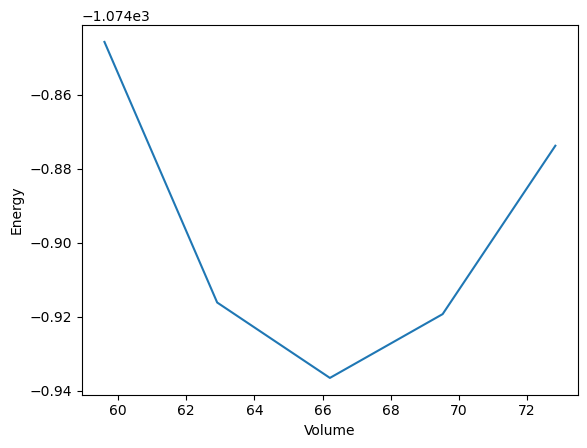

In [21]:
wg.run()

## Load Workflow with pyiron_base

In [22]:
from pyiron_base import Project

In [23]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [24]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

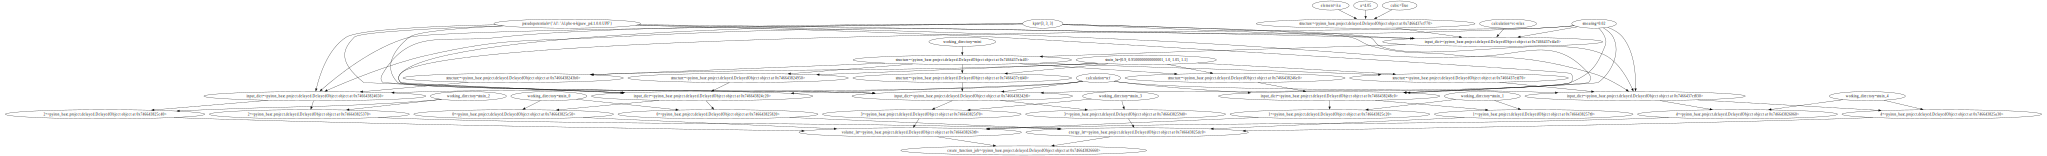

In [25]:
delayed_object_lst = load_workflow_json(project=pr, file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [26]:
delayed_object_lst[0]._input['kwargs']['element'] = "Al"

The job get_bulk_structure_f1e730ed97e30e5439e855d2ac41396f was saved and received the ID: 1
The job get_dict_1e47509b88d63a21fd421686554c8f4a was saved and received the ID: 2
The job calculate_qe_e3c0bf43f7edf24d215901bf93271e87 was saved and received the ID: 3


[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:00666] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_1b7c58a6c97034828c45264d1a87f929 was saved and received the ID: 4
The job get_dict_dd713a0e2845ac97eaf3e34b2bf4ff1d was saved and received the ID: 5
The job calculate_qe_7732b997356479490d85edcad7e4702a was saved and received the ID: 6


[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:00676] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_0feba86f84979ee338045027ed5bab30 was saved and received the ID: 7
The job calculate_qe_8f0147230b93a4d653dce8e2ff5e1d1a was saved and received the ID: 8


[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:00686] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_37d80c3e0a72c27ab0360d5d7f7eda80 was saved and received the ID: 9
The job calculate_qe_8e5f29f162cc1de9d98b8e338f727f72 was saved and received the ID: 10


[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:00697] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_26793a4d8075e4656f1f19ee1eafb1ce was saved and received the ID: 11
The job calculate_qe_47f64a99c1ffe809dd320d4a485196f6 was saved and received the ID: 12


[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:00710] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_5dd500d36995319000b3da5b9ed37156 was saved and received the ID: 13
The job calculate_qe_98a370d003b6094baa7425853ecad00c was saved and received the ID: 14


[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:00722] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_1096f328a75f59d1d7b665a86ab8123b was saved and received the ID: 15
The job get_list_d466ca26cf9687e8330516c496757848 was saved and received the ID: 16
The job plot_energy_volume_curve_b654cec877cbc95427742008a02c9c39 was saved and received the ID: 17


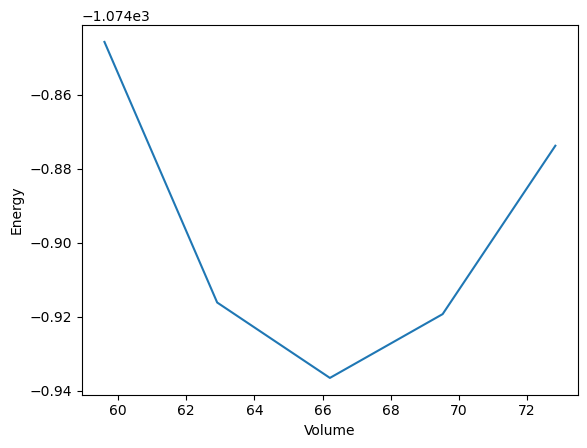

In [27]:
delayed_object_lst[-1].pull()